In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# import data (just deal with level a for now)
data = pd.read_csv('OLIDv1.0/olid-training-v1.0.tsv', sep='\t', header=0, names=['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'])
data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


# Char-Level LSTM
## Preprocessing and Downsampling

In [3]:
import re
import emoji
import itertools

def preprocess(tweet):
    # TODO: handles are comming up at @ user instead of @user, need to fix that
    # remove hashtags
    tweet = ' '.join(re.sub("(#[A-Za-z0-9]+)", " ", tweet).split())
    # remove non-ascii characters
    tweet = tweet.encode("ascii", "ignore").decode()
    # remove punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    # lowercase
    tweet = tweet.lower()
    # replace emoji with text rep
    tweet = emoji.demojize(tweet)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())
    # standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    return tweet

data.tweet = [preprocess(tweet) for tweet in data.tweet]
# dev.tweet = [preprocess(tweet) for tweet in dev.tweet]
# train.tweet = [preprocess(tweet) for tweet in train.tweet]

In [4]:
print(data.tweet[922])

*gets period* you are the cause of my


In [16]:
off_df = data[data.subtask_a == 'OFF'].drop(['subtask_b', 'subtask_c'], axis=1)
not_df = data[data.subtask_a == 'NOT'].drop(['subtask_b', 'subtask_c'], axis=1)
not_df.tweet.head()

2     amazon is investigating chinese employees who ...
4     @user @user obama wanted liberals &amp illegal...
8                               @user buy more icecream
10    @user @user @user its not my fault you support...
11    @user whats the difference between and @user o...
Name: tweet, dtype: object

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64


[Text(0.5, 0, 'Tweets'), Text(0, 0.5, 'Counts')]

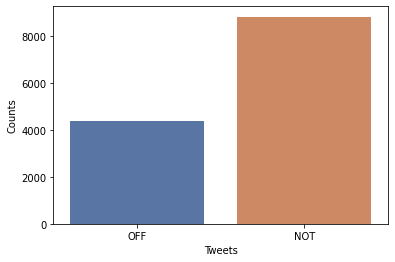

In [334]:
# investigating class imbalance
import seaborn as sns
print(data.subtask_a.value_counts())
ax = sns.countplot(x='subtask_a', data=data, label='Offensive Language', palette='deep')
ax.set(xlabel='Tweets', ylabel='Counts')

In [18]:
## downsampling
not_df = not_df.sample(n=len(off_df), random_state=12)
print(not_df.shape, off_df.shape)


(4400, 3) (4400, 3)


/Users/hope/miniconda3/envs/nlp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='subtask_a', ylabel='count'>

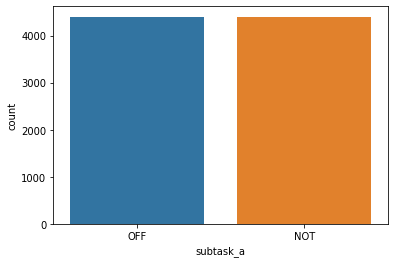

In [19]:
df = off_df.append(not_df).reset_index(drop=True)
sns.countplot(df.subtask_a)

In [20]:
# get length column for each text
df['text_length'] = df.tweet.apply(len)

# get average char length by  label types
labels = df.groupby('subtask_a').mean()
labels

,id,text_length
subtask_a,,
NOT,55105.063409,113.716136
OFF,54229.596818,125.134318


## Splitting into train/dev

In [226]:
df['type'] = df['subtask_a'].map({'OFF': 1, 'NOT':0})
label = df.type.values

# data['type'] = data['subtask_a'].map({'OFF': 1, 'NOT':0})
# label = data.type.values

# split into train/dev
train, dev = sklearn.model_selection.train_test_split(df, test_size=0.1, random_state=0) 
dev = dev.reset_index(drop=True)
train = train.reset_index(drop=True)

train.head()

,id,tweet,subtask_a,text_length,type
0,98777,@user should i share the quotes from notable u...,NOT,62,0
1,54306,@user @user hillary why is she on the social s...,OFF,248,1
2,97304,@user @user @user @user you are in the spirit ...,NOT,55,0
3,26792,@user why you ruin shit lol,OFF,27,1
4,94391,@user @user only liberals sexuality childrens ...,NOT,53,0


In [274]:
from keras.utils import to_categorical

lstm_train_seqs = train.tweet
lstm_train_labs = train.type

lstm_train_labs = to_categorical(train.type)

lstm_dev_seqs = dev.tweet
lstm_dev_labs = dev.type

lstm_dev_labs = to_categorical(dev.type)

print(lstm_train_labs[:5])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


## Model and Hyperparameter Definition 

In [321]:
# Defining pre-processing hyperparameters
max_len = 50 # extended tweet char limit
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 1000 # maximum number of unique tokens hence we can filter out rare words

## loading pretrained FastText Vectors

In [322]:
from urllib.request import urlopen
import gzip

# file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.vec.gz'))
# # file = open('wiki-news-300d-1M-subword.vec', 'r')
# vectors = {}
# for line in file:
#     values = line.split()
#     word = values[0].decode('utf-8')
#     vector = np.array(values[1:], dtype='float32')
#     vectors[word] = vector

# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

# vectors = load_vectors('wiki-news-300d-1M-subword.vec')

In [323]:
print(len(vectors.keys()))

2000000


In [324]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

word_tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token= oov_tok)
word_tokenizer.fit_on_texts(lstm_train_seqs)

In [325]:
word_index = word_tokenizer.word_index
# check how many words 
tot_word = len(word_index)
print('There are %s unique words in training data. ' % tot_word) 

# Sequencing and padding on training and dev data
training_sequences = word_tokenizer.texts_to_sequences(lstm_train_seqs)
training_padded = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

dev_sequences = word_tokenizer.texts_to_sequences(lstm_dev_seqs)
dev_padded = pad_sequences(dev_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of dev tensor: ', dev_padded.shape)

print(training_padded[0])

There are 13781 unique words in training data. 
Shape of training tensor:  (7920, 50)
Shape of dev tensor:  (880, 50)
[  2  80  11   1   3   1  55   1 122 431  49   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [326]:
# hyperparams
# vocab_size = 500 # As defined earlier
embedding_dim = 300
drop_value = 0.2 # dropout


In [327]:
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [328]:
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, TimeDistributed

# LSTM model architecture
model = Sequential()
# char_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Embedding(len(word_index)+1, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, dropout=drop_value)))
# char_model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 300)           4134600   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50, 100)           140400    
_________________________________________________________________
global_average_pooling1d_15  (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 4,275,202
Trainable params: 140,602
Non-trainable params: 4,134,600
_________________________________________________________________


In [329]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history2 = model.fit(training_padded, lstm_train_labs, epochs=num_epochs, validation_data=(dev_padded, lstm_dev_labs),\
                    callbacks =[early_stop], verbose=2)

Train on 7920 samples, validate on 880 samples
Epoch 1/30
7920/7920 - 11s - loss: 0.6862 - accuracy: 0.5452 - val_loss: 0.6824 - val_accuracy: 0.5716
Epoch 2/30
7920/7920 - 8s - loss: 0.6570 - accuracy: 0.6140 - val_loss: 0.6686 - val_accuracy: 0.5920
Epoch 3/30
7920/7920 - 8s - loss: 0.6399 - accuracy: 0.6308 - val_loss: 0.6414 - val_accuracy: 0.6159
Epoch 4/30
7920/7920 - 8s - loss: 0.6184 - accuracy: 0.6480 - val_loss: 0.6481 - val_accuracy: 0.6136
Epoch 5/30
7920/7920 - 8s - loss: 0.6042 - accuracy: 0.6698 - val_loss: 0.6271 - val_accuracy: 0.6364
Epoch 6/30
7920/7920 - 8s - loss: 0.5913 - accuracy: 0.6823 - val_loss: 0.6126 - val_accuracy: 0.6409
Epoch 7/30
7920/7920 - 8s - loss: 0.5788 - accuracy: 0.6894 - val_loss: 0.6202 - val_accuracy: 0.6466
Epoch 8/30
7920/7920 - 8s - loss: 0.5692 - accuracy: 0.7072 - val_loss: 0.6111 - val_accuracy: 0.6670
Epoch 9/30
7920/7920 - 8s - loss: 0.5584 - accuracy: 0.7109 - val_loss: 0.6167 - val_accuracy: 0.6534
Epoch 10/30
7920/7920 - 8s - loss:

In [305]:
# this still exists
char_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 140, 300)          18300     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 140, 100)          140400    
_________________________________________________________________
global_average_pooling1d_13  (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 202       
Total params: 158,902
Trainable params: 140,602
Non-trainable params: 18,300
_________________________________________________________________


In [330]:
test = pd.read_csv('OLIDv1.0/testset-levela.tsv', sep='\t', header=0, names=['id', 'tweet'])
test.tweet = [preprocess(tweet) for tweet in test.tweet]

# test.tweet = ruin(test)

test_sequences = word_tokenizer.texts_to_sequences(test.tweet)
test_padded = pad_sequences(test_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)
print(test_padded.shape)
test_y = pd.read_csv('OLIDv1.0/labels-levela.csv', sep=',', header=None, names=['id', 'label'])
y_true = list(test_y.label.map({'OFF': 1, 'NOT':0}))


preds = model.predict(test_padded)#, test_y) 
# get the max
y_hat = [np.argmax(preds[i]) for i in range(len(preds))]
print(preds[:5])
print(y_hat[:5])
print(y_true[:5])
print(classification_report(y_true, y_hat))


(860, 50)
[[0.6333401  0.36665988]
 [0.505089   0.494911  ]
 [0.85827464 0.14172542]
 [0.5738131  0.42618695]
 [0.4402488  0.5597513 ]]
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 1]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       620
           1       0.45      0.63      0.52       240

    accuracy                           0.68       860
   macro avg       0.64      0.66      0.64       860
weighted avg       0.72      0.68      0.69       860



In [ ]:
# now we have char_model. don't have to build it again just why did I even train it on the adversarial data, just need to predict on screwed up data
# re-get model
# then just format the y_hat
# LOLOLOLOL

# Adversarial Input for the LSTM

# FastText Classifier

In [33]:
# split into train/dev
# NOT DOWNSAMPLED
train, dev = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=0)
train.subtask_a.value_counts()

NOT    7939
OFF    3977
Name: subtask_a, dtype: int64

## Formatting data into FastText form and saving to CSV

In [42]:
from nltk import word_tokenize

def get_fastText(data):
   fastTweet = [word_tokenize('__label__' + label + ' ' + tweet) for label, tweet in zip(data.subtask_a, data.tweet)]
   return fastTweet

import csv
  
def make_file(data, output_file, is_test=False):    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        for row in get_fastText(data):
            csv_writer.writerow(row)

make_file(train, 'data/tweets.train')
make_file(dev, 'data/tweets.dev')

In [141]:
## FastText classifier ##
import os
import fasttext

# reloading already trained model
# model = fasttext.load_model('models/fasttext.ftz')

def train_fasttext(train, dev):
    # ###################
    hyper_params = {"lr": 0.01,
                    "epoch": 100,
                    "wordNgrams": 2,
                    "dim": 20}     

    model = fasttext.train_supervised(input=os.path.join('data',train), **hyper_params)
    # reduces size of model and saves
    # model.quantize(input='tweets.train', qnorm=True, retrain=True, cutoff=100000)
    # model.save_model(os.path.join('models/','fasttext_downsampled' + ".ftz"))
    # ###################

    model_acc_training_set = model.test(os.path.join('data',train))
    model_acc_validation_set = model.test(os.path.join('data',dev))
    # DISPLAY ACCURACY OF TRAINED MODEL
    text_line = str(hyper_params) + " \naccuracy: " + str(model_acc_training_set[1])  + "\nvalidation: " + str(model_acc_validation_set[1]) + '\n' 
    print(text_line)
    return model


In [176]:
from sklearn.metrics import classification_report
model = train_fasttext('tweets.train', 'tweets.dev')

def get_preds(model, test_data):
    # involves some parsing to get just the letters 'OFF' or 'NOT
    return[model.predict(tweet)[0][0][-3:] for tweet in test_data.tweet]

def evaluate_fasttext(model, adv = False):
    test = pd.read_csv('OLIDv1.0/testset-levela.tsv', sep='\t', header=0, names=['id', 'tweet'])
    test.tweet = [preprocess(tweet) for tweet in test.tweet]
    
    
    
    if adv:
        test.tweet = ruin(test)
    
    y_hat = get_preds(model, test)
    
    test_y = pd.read_csv('OLIDv1.0/labels-levela.csv', sep=',', header=None, names=['id', 'label'])
    y_true = test_y.label
    print(classification_report(y_true, y_hat))
    
evaluate_fasttext(model)


{'lr': 0.01, 'epoch': 100, 'wordNgrams': 2, 'dim': 20} 
accuracy: 0.9866565961732124
validation: 0.7779456193353474

              precision    recall  f1-score   support

         NOT       0.83      0.89      0.86       620
         OFF       0.64      0.52      0.57       240

    accuracy                           0.78       860
   macro avg       0.73      0.70      0.71       860
weighted avg       0.77      0.78      0.78       860



# Adversarial Examples

In [102]:
from random import choice

def mispell(word):
    word = list(word)
    x = choice(range(4))

    if x == 0:
    # shuffle
        idx = choice(np.arange(len(word)-2))
        before = word[:idx]
        subset = word[idx:idx+2]
        after = word[idx+2:]
        subset = subset[::-1]
        word = before + subset + after
    if x == 1:
    # drop letters
        idx = choice(np.arange(len(word)))
        word = word[:idx] + word[idx+1:]
    if x == 2:
    # repeat a letter
        idx = choice(np.arange(len(word)))
        word = word[:idx] + [word[idx]] + word[idx:]
    if x == 3:
    # add period at random place
        idx = choice(np.arange(len(word)))
        word = word[:idx] + ['.'] + word[idx:]
    return ''.join(word)

print(mispell('motherfucking'))

# Just do this for a hot sec. 
# print([mispell(word) for word in NSFW])

def negate(word):
    pass
    

moterfucking


In [346]:
# modify train and dev with some proportion of the set being 
# adv = data.copy()

def ruin(data):
    adv = data.copy()
    NSFW = set(['fuck', 'damn', 'shit','dumbass', 'ass', \
                'bad', 'moron', 'idiot', 'mean', 'dumb', \
                'communist','terrible', 'cock', 'liberal', \
                'maga', 'democrat', 'conservative', 'trump', \
                'antifa', 'sick', 'toxic'])
    count = 0
    for ii, sent in enumerate(adv.tweet):
        words = sent.split()
        for jj, word in enumerate(words):
            # there will be some false positives, it's okay
            for bad_word in NSFW:
                if bad_word in word:
                    # also maybe add randomness in here, like a 50/50 chance it does permute
                    words[jj] = mispell(word)
                    new = ' '.join(words)
#                     print()
#                     print(adv.subtask_a[ii])
                    print(words)
                    
                    print(new)
                    adv.tweet[ii] = new       
                    count += 1
    print(count) # 7492 subs
    return adv.tweet



In [347]:
ruin(test[:100])

['dmeocrats', 'support', 'antifa', 'muslim', 'brotherhood', 'ms13', 'isis', 'pedophilia', 'child', 'trafficking', 'taxpayer', 'funded', 'abortions', 'election', 'fraud', 'sedition', 'and', 'treason', '@user', 'url']
dmeocrats support antifa muslim brotherhood ms13 isis pedophilia child trafficking taxpayer funded abortions election fraud sedition and treason @user url
['dmeocrats', 'support', 'antiffa', 'muslim', 'brotherhood', 'ms13', 'isis', 'pedophilia', 'child', 'trafficking', 'taxpayer', 'funded', 'abortions', 'election', 'fraud', 'sedition', 'and', 'treason', '@user', 'url']
dmeocrats support antiffa muslim brotherhood ms13 isis pedophilia child trafficking taxpayer funded abortions election fraud sedition and treason @user url
['is', 'revered', 'by', 'con.servatives', 'hated', 'by', 'progressives/socialist/democrats', 'that', 'want', 'to', 'change', 'it']
is revered by con.servatives hated by progressives/socialist/democrats that want to change it
['is', 'revered', 'by', 'con.se

/Users/hope/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     dmeocrats support antiffa muslim brotherhood m...
1     is revered by con.servatives hated by progress...
2     @user @user @user @user @user @user @user @use...
3     getting the news that she is still up for paro...
4     unity demo to oppose the far right in enough i...
                            ...                        
95             url we have what you are looking for url
96    put wallin budget you are going to loose pres ...
97    hi @user this is fiona she is about 10 weeks o...
98    the conversation about this is so unattractive...
99    is so full of herself she is just as painful t...
Name: tweet, Length: 100, dtype: object

In [339]:
train_adv, dev_adv = sklearn.model_selection.train_test_split(adv, test_size=0.1, random_state=0)
train_adv.subtask_a.value_counts()

make_file(train_adv, 'data/tweets.adv.train')
make_file(dev_adv, 'data/tweets.adv.dev')

model_adv = train_fasttext('tweets.adv.train', 'tweets.adv.dev')
evaluate_fasttext(model_adv, adv=True)

{'lr': 0.01, 'epoch': 100, 'wordNgrams': 2, 'dim': 20} 
accuracy: 0.9869922792883518
validation: 0.7507552870090635



AttributeError: 'DataFrame' object has no attribute 'subtask_a'

## Testing Sentences for the chart

Okay well we definitely need ones from the test set, not the trian set

In [167]:
print(model.predict("@user someone should've taken this piece of shit to a volcano")) # 99.99%
print(model.predict("@user someone should've taken this piece of sht to a volcano")) # 74.88 %

(('__label__OFF',), array([0.99990022]))
(('__label__OFF',), array([0.74872291]))


In [170]:
print(model.predict("@user liberaals are all kookoo")) # 85
print(model.predict("@user liberals are all kookoo")) #98

(('__label__OFF',), array([0.85089403]))
(('__label__OFF',), array([0.98458773]))


In [188]:
print(model.predict("@user @user @user trump is a very sick man he is toxic and mean spirited")) # 99.6
print(model.predict("@user @user @user trmup is a very siick man he is toxc and me.an spirited")) #98.5


(('__label__OFF',), array([0.9957692]))
(('__label__OFF',), array([0.55787367]))


In [348]:
print(model_adv.predict('are you fucking serious url'))
print(model_adv.predict('are you not fucking serious url'))
#                     

(('__label__OFF',), array([0.68974441]))
(('__label__NOT',), array([0.68345487]))


In [343]:
print(model_adv.predict('@user trump kicks dem butt its not so fun'))
print(model_adv.predict('@user trump kicks dem butt its so fun'))

(('__label__OFF',), array([0.97192186]))
(('__label__OFF',), array([0.98201859]))


In [349]:
print(model_adv.predict('@user he is competing for worst president again'))
print(model_adv.predict('@user he is not competing for worst president again'))


(('__label__OFF',), array([0.95972419]))
(('__label__OFF',), array([0.8462193]))


In [350]:
print(model_adv.predict('shit i will drown twitter in bullshhit if one of those is banned'))
print(model_adv.predict('shit i will not drown twitter in bullshhit if one of those is banned'))



(('__label__NOT',), array([0.93584484]))
(('__label__NOT',), array([0.84804094]))


In [184]:
#     print(sent.split())
# print(adv[adv.tweet.str.count('cock')>1].subtask_a.value_counts())
# print([mispell(word) for word in NSFW])
# fuck Off: 20, Not: 0
# ass Off: 37, Not: 29
# damn Off: 0, Not: 1
# bad Off: 3, Not: 7
# idiot Off: 2, Not : 0
# mean Off: 8, Not: 9
# dumb Off: 2, Not: 1
# terrible Off: 1, Not: 1
# cock: Off:1, Not: 0

# liberal Off: 65, Not: 74
# maga Off: 1, Not: 4 
# conservative: Off: 17, Not: 49
# trump Off: 29, Not: 44
# antifa Off: 10, Not: 32


In [52]:
# edit distance! This is a good way to do this. have an edit distance generator and then you can plot quantitatively by how large the edit distance is. 

# self-censorship of profanity
##  having a set of replacement spellings in a dictionary ('idiot': ['iidiot', 'i.diot'])
# sneaky = {'dumbass': 'dumb@$$', 
# 'pussy': 'pu$$y', 
# 'ass': 'a$$', 
# 'fuck': 'f*ck', 
# 'fucking': 'f*cking', 
# 'hell':'h*ll', 
# 'cunt': 'c*nt',
# 'hoe': 'h*e',
# 'sex': 's*x'
# }